# PARAMETERS

In [136]:
# NOTINREPORT
%run ./src/Modules.ipynb   
changeParameters(lr = False, nbp = False, mfa = False)


button = widgets.Button(description="Save parameters")
output = widgets.Output()

display(button, output)

def on_button_clicked(b):
    np.savetxt( './src/parameters.csv',
            [[sampleName_p.value,previousPowerOf2(int(min(10, measureDuration_p.value)* 125e6 / 16384)) * 16384 / 125e6, Rload_p.value, nbCycles_p.value, Rcircuit_p.value, fourrierMaxFreq_p.value]],
            delimiter=",",
            fmt='%s',
            header = 'Sample name, Measure duration, Rload, Nb Periods, R Circuit, Max Frequency'
            )
        
button.on_click(on_button_clicked)

Button(description='Save parameters', style=ButtonStyle())

Output()

In [137]:
### Print sample name and define folder
parameters = np.loadtxt('./src/parameters.csv', delimiter=",", comments='#', dtype=str)
sampleName = parameters[0]

folder = './data/{}/{}_{}/{}/{}h{}/{}/'.format(date.today().strftime('%Y'), date.today().strftime('%m'), date.today().strftime('%B'), date.today().strftime('%d'), str(time.localtime().tm_hour).zfill(2), str(time.localtime().tm_min).zfill(2), sampleName)

print('Sample name: ' + str(sampleName))

Sample name: ZNO-109-30min


In [138]:
### Print parameters

parameters = np.loadtxt('./src/parameters.csv', delimiter=",", comments='#', dtype=str)

measureDuration = float(parameters[1])
Rcircuit = float(parameters[4])

pd.DataFrame(   np.array([
                ['Sample name', 'Measure duration', 'R Circuit'],
                [sampleName, measureDuration, Rcircuit],
                ['', '[s]', '[Ohms]'] ]).transpose(),
                columns=['Parameter', 'Value', 'Unit'],
            )

,Parameter,Value,Unit
0,Sample name,ZNO-109-30min,
1,Measure duration,1.073741824,[s]
2,R Circuit,1000000.0,[Ohms]


# MEASUREMENTS

A window will apppear and ask for the resistance value you selected. Write it down using the following format:
1000 or 1e3 or 1E3
Then press enter and wait for the window to appear again for the next measurement.
When the number of measurements is sufficient, write done in the window instead of the resistance value and press enter. This will record and stop the experiment.

In [139]:
import time as t
RloadArr = []
VmeanArr = []
PmeanArr = []
MaxPressArr = []
MeanPressArr = []


while 1:
    setUpRFInputs(measureDuration)
    inP = ''
    while inP.replace('e', '').replace('E', '').replace('.', '').isdigit() == False and inP != 'done':
        inP = input('Load resistance [Ohms]')
        if inP.replace('e', '').replace('E', '').replace('.', '').isdigit() == False and inP != 'done':
            print('Please use the following format: 100 or 1e2')
    if inP == 'done': break
    t0 = t.time()
    Rload = float(inP)
    # Perform measurements
    # Update the folder with the date/time of the experiment
    folder              = './data/{}/{}_{}/{}/{}h{}/{}/'.format(date.today().strftime('%Y'), date.today().strftime('%m'), date.today().strftime('%B'), date.today().strftime('%d'), str(time.localtime().tm_hour).zfill(2), str(time.localtime().tm_min).zfill(2), sampleName)

    voltage, pressure   = getRFInputs()     
                                # Get data from RedPitaya
    pressure.y          *= 0.7 / 5    
    power               = data( voltage.t, voltage.y ** 2 / ( Rload + Rcircuit ))                                                                # Convert from V to Bar


    MaxPressArr.append(np.max(pressure.y))
    MeanPressArr.append(np.mean(pressure.y))
    RloadArr.append(Rload)
    VmeanArr.append(np.mean(abs(voltage.y)))
    PmeanArr.append(np.mean(abs(power.y)))

Rload = np.array(Rload) + Rcircuit
    

# GRAPHS

Pressure average [mBar]: 167.5 ±   7.8
Pressure variance [mBar]: 0.009939236111111142
Excitation frequency [Hz] : 13.03931190105597


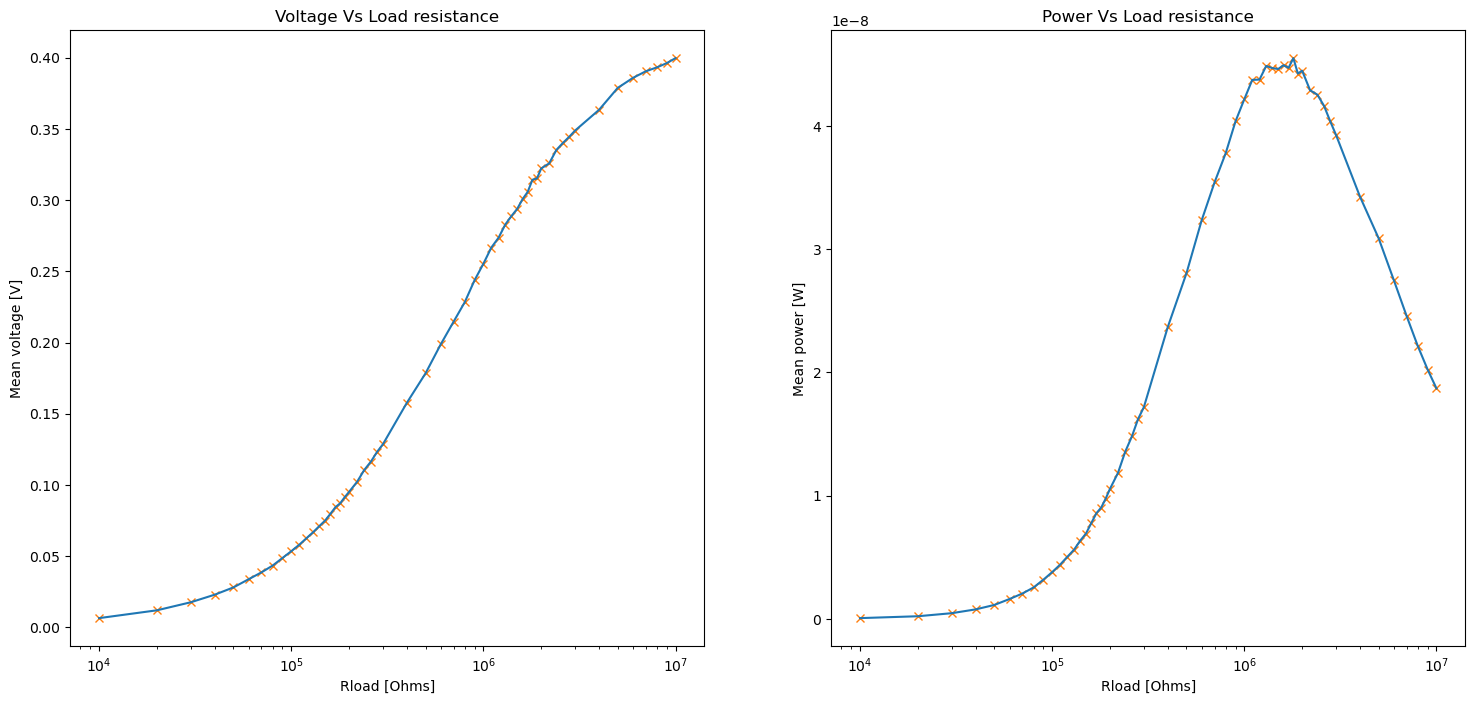

In [140]:
VmeanData = graph(RloadArr, VmeanArr, 'Rload [Ohms]', 'Mean voltage [V]', 'Voltage Vs Load resistance')
PmeanData = graph(RloadArr, PmeanArr, 'Rload [Ohms]', 'Mean power [W]', 'Power Vs Load resistance')

info =  '\n'.join([
    'Pressure average [mBar]: %5.1f ± %5.1f'%(1000*np.mean(MeanPressArr), 1000*max(abs(np.mean(MeanPressArr) - min(MeanPressArr)), abs(np.mean(MeanPressArr) - max(MeanPressArr)))),
    'Pressure variance [mBar]: '+str(1000*np.var(MaxPressArr)),
    'Excitation frequency [Hz] : '+str(pressure.getFrequency())
        ])
print(info)
#+str(1000*np.mean(MeanPressArr)) + ' ± '+str(max(abs(np.mean(MeanPressArr) - min(MeanPressArr)), abs(np.mean(MeanPressArr) - max(MeanPressArr))))
plotGraph([VmeanData], [PmeanData], 'VandPVsResistance', log=True, points = True)

exportData = [RloadArr, VmeanArr, PmeanArr]
exportHeader = "R load [Ohms], Mean absolute voltage [V], Mean instant power [W]"

np.savetxt( folder+sampleName+'.data.csv',
                np.asarray(exportData, dtype=np.double).transpose(),
                header=exportHeader,
                delimiter=",") 

np.savetxt(folder+sampleName+'.info.txt',  np.asarray([]), header=info, delimiter=",")

In [141]:
PmeanArr[12]/=10
print(PmeanArr[12])

5.618456275062224e-10


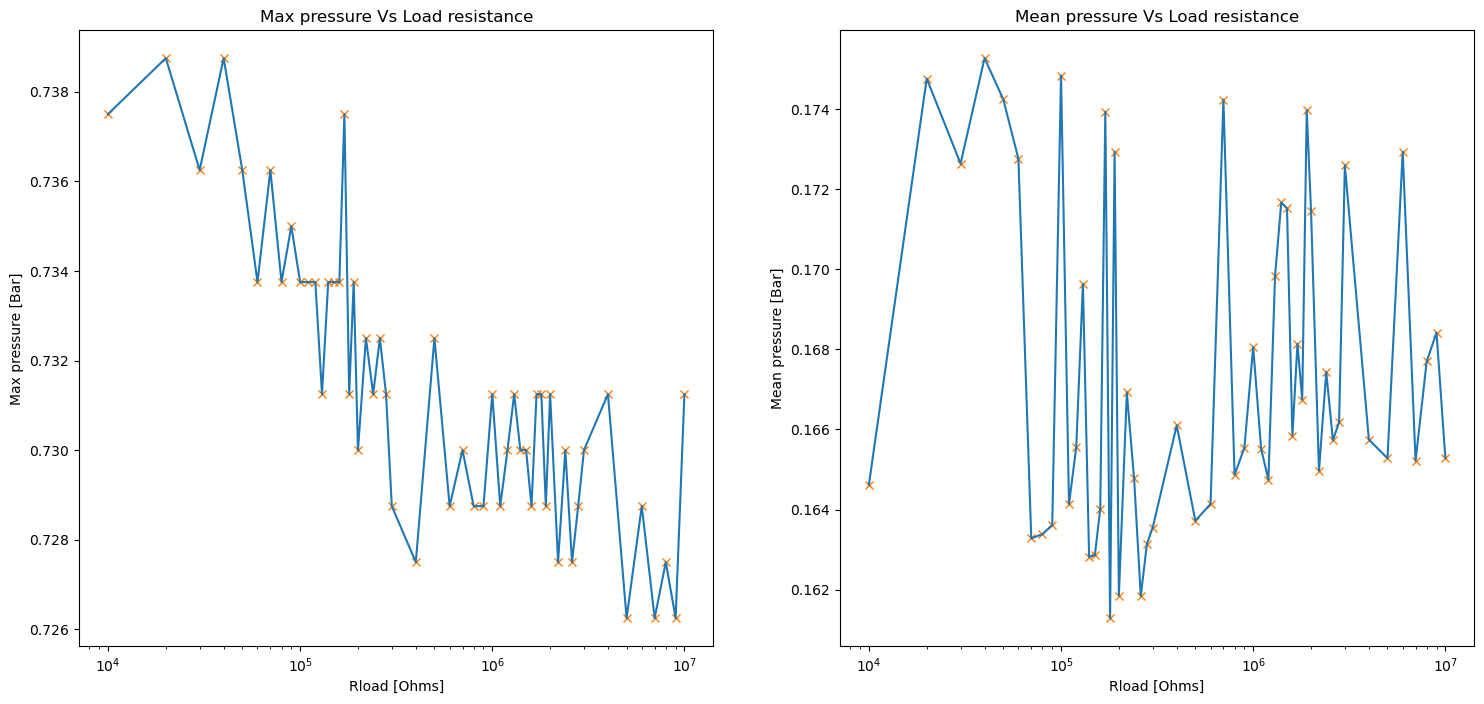

In [142]:
PressureMaxData = graph(RloadArr, MaxPressArr, 'Rload [Ohms]', 'Max pressure [Bar]', 'Max pressure Vs Load resistance')
PressureMeanData = graph(RloadArr, MeanPressArr, 'Rload [Ohms]', 'Mean pressure [Bar]', 'Mean pressure Vs Load resistance')
plotGraph([PressureMaxData], [PressureMeanData], 'PressureVsResistance', log=True, points = True)

In [143]:
print(PmeanArr)

[6.944108717512376e-11, 2.2177527932559742e-10, 4.688948103525106e-10, 7.791984998262845e-10, 1.1377171107700893e-09, 1.6186213943193545e-09, 2.0662371911735176e-09, 2.5534682803683812e-09, 3.186630109034547e-09, 3.798077670010653e-09, 4.405029915474557e-09, 5.046880585806709e-09, 5.618456275062224e-10, 6.355852829782586e-09, 6.929400568423064e-09, 7.792428444171773e-09, 8.584380516639123e-09, 9.035532353288036e-09, 9.76765320080669e-09, 1.0557178179423014e-08, 1.1840747770715933e-08, 1.3563158589024698e-08, 1.4809167650010851e-08, 1.6219952702522278e-08, 1.7174133007343e-08, 2.3694974081856863e-08, 2.8040409088134764e-08, 3.2338337421417235e-08, 3.541139176312615e-08, 3.777497630649143e-08, 4.036175075330233e-08, 4.215648212432861e-08, 4.37249623253232e-08, 4.375175493413752e-08, 4.48565673828125e-08, 4.468277994791667e-08, 4.460715301513671e-08, 4.491465436495267e-08, 4.470283635457357e-08, 4.549102742331369e-08, 4.423829874499091e-08, 4.447200762430827e-08, 4.288210189342499e-08, 4.